Note : All work has been done using R language.

In [ ]:
library(fst)
library(data.table)
library(tidyverse)
library(lubridate)
library(stringr)
library(broom)
library(zoo)
options(repr.plot.width=15)
options(scipen=999)

In [2]:
serialized_data_path <- 'data_serialized/'
files <- list.files(serialized_data_path)

## Reading data

In [3]:
for(i in files){
    obj_name <- gsub('.fst','',i)
    eval(parse(text=sprintf('%s <- read.fst("%s%s",as.data.table=T)',obj_name,serialized_data_path,i)))
}

## Checking uniqueness for primary key ;

In [4]:
economic_variables[,.(n=.N),by=pk][n > 1]

economic_calendar[,.(n=.N),by=pk][n > 1]

transactions[,.(n=.N),by=pk][n > 1]

pk,n
<int>,<int>


pk,n
<int>,<int>


pk,n
<int>,<int>


I've grouped each table by `pk` and checked their frequency, looks okay.

## Manipulating Data

### Well formatting `ga_datehour`

In [5]:
transactions[,ga_datehour := ymd_h(ga_datehour)]
name_template <- colnames(transactions[0])
transactions %>% head(5)

pk,ga_transactionid,ga_datehour,ga_products,ga_channels,ga_itemquantity
<int>,<chr>,<dttm>,<chr>,<chr>,<int>
146288072,2_50414543,2020-08-29,Product D,Facebook,1
146288071,2_50414542,2020-08-29,Product D,Organic search,1
146287503,2_50413935,2020-08-29,Product D,Organic search,1
146287504,2_50413936,2020-08-29,Product D,Organic search,1
146296436,3_65496155,2020-08-29,Product E,Google Ads,1


### Replacing empty string values ('') with `NA`

In [6]:
transactionsa <- transactions[,lapply(.SD,function(x) ifelse(x=='',NA,x)),.SD=is.character]
transactionsb <- transactions[,.SD,.SDcols=!is.character]
transactions <- cbind(transactionsb,transactionsa)
                                          
rm(transactionsa)
rm(transactionsb)
gc()
                                          
setDT(transactions)
                                              
transactions <- transactions[,.SD,.SDcols=name_template]
transactions %>% head(5)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,20059338,1071.3,43139458,2303.9,20248403,1081.4
Vcells,152529142,1163.8,464792048,3546.1,382773376,2920.4


pk,ga_transactionid,ga_datehour,ga_products,ga_channels,ga_itemquantity
<int>,<chr>,<dttm>,<chr>,<chr>,<int>
146288072,2_50414543,2020-08-29,Product D,Facebook,1
146288071,2_50414542,2020-08-29,Product D,Organic search,1
146287503,2_50413935,2020-08-29,Product D,Organic search,1
146287504,2_50413936,2020-08-29,Product D,Organic search,1
146296436,3_65496155,2020-08-29,Product E,Google Ads,1


### Parsing `ga_datehour` to work easier

In [7]:
transactions[,year := year(ga_datehour)]
transactions[,month := month(ga_datehour)]
transactions[,day := day(ga_datehour)]
transactions[,hour := hour(ga_datehour)]
transactions[,week_day := as.character(wday(ga_datehour,label = T))]

transactions %>% head(5)

pk,ga_transactionid,ga_datehour,ga_products,ga_channels,ga_itemquantity,year,month,day,hour,week_day
<int>,<chr>,<dttm>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>
146288072,2_50414543,2020-08-29,Product D,Facebook,1,2020,8,29,0,Cts
146288071,2_50414542,2020-08-29,Product D,Organic search,1,2020,8,29,0,Cts
146287503,2_50413935,2020-08-29,Product D,Organic search,1,2020,8,29,0,Cts
146287504,2_50413936,2020-08-29,Product D,Organic search,1,2020,8,29,0,Cts
146296436,3_65496155,2020-08-29,Product E,Google Ads,1,2020,8,29,0,Cts


In [8]:
quantity_check <- transactions[,table(.SD),.SDcols='ga_itemquantity']

quantity_check

quantity_check <- data.frame(quantity_check)

setnames(quantity_check,'.SD',new = 'quantity')
setDT(quantity_check)

quantity_check[,.(NOT_1 = sum(.SD[quantity!=1])/sum(.SD)),.SDcols='Freq']

.SD
       1        2        3        4 
20824680     7120        8        1 

NOT_1
<dbl>
0.000342217


### As seen above, %0.003 of observations of `ga_itemquantity` recorded is different from 1, It's hard to do some analysis on this kind of unbalanced distrubiton. The best and fastest solution is keeping only 1.

-----------

### Calculating of daily and hourly visitor numbers, number of leads and creating a summary table

In [9]:
visitors <- transactions[ga_itemquantity == 1,
                         .(visitor_num = .N),
                         by=c('year','month','day','hour','week_day','ga_channels','ga_products')]

visitors[,year_day := yday(as.Date(ISOdate(year = year,month=month,day=day)))]

visitors %>% head(5)

year,month,day,hour,week_day,ga_channels,ga_products,visitor_num,year_day
<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>
2020,8,29,0,Cts,Facebook,Product D,55,242
2020,8,29,0,Cts,Organic search,Product D,184,242
2020,8,29,0,Cts,Google Ads,Product E,6,242
2020,8,29,0,Cts,Google Ads,Product D,895,242
2020,8,29,0,Cts,Organic search,Product E,27,242


In [10]:
rm(transactions)

In [11]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1168438,62.5,34511567,1843.2,20297413,1084.0
Vcells,12475389,95.2,448725400,3423.6,473020589,3608.9


In [12]:
visitors[,pure_date := as.Date(ISOdate(year=year,month = month,day = day)),]

### Subsetting data where `economic variables` end `economic calendar` are avaliable

In [13]:
visitors_sub <- visitors[pure_date>=min(economic_variables[,date]) & pure_date<=max(economic_variables[,date])]

In [14]:
visitors %>% nrow

[1] 245124

### Joining economic variables with visitors table

In [15]:
visitors_sub %>% 
rename(date = pure_date) %>% 
left_join(economic_variables %>%
          mutate(date=as.Date(date)) %>% 
          select(-pk),by=c('date','hour')) -> joint_table

In [16]:
joint_table[,record_num := 1:.N,by='date']

Warning message in `[.data.table`(joint_table, , `:=`(record_num, 1:.N), by = "date"):
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


In [17]:
joint_table[record_num==1,is_empty_first_day := is.na(bist100)]

### To fully fill all columns I am rolling values between two hours if there is no record for that hour.

In [18]:
columns_to_initialize <- colnames(economic_variables[,-c('pk','hour')])

na_days <- joint_table[is_empty_first_day==TRUE,'date']

needed_cols <- economic_variables[,..columns_to_initialize]
needed_cols[,n := 1:.N,by=date]
needed_cols[,date := c(date[1],lag(date)[-1])]
needed_cols <- needed_cols[,.SD[which.max(n)],by=date]
needed_cols[,n := NULL]
imputation <- left_join(na_days,needed_cols %>% mutate(date=as.Date(date)),by='date')
                                   
joint_table[is_empty_first_day==TRUE,(columns_to_initialize) := imputation,]

In [19]:
joint_table[,bist100 := na.locf(bist100)]
joint_table[,usdtry := na.locf(usdtry)]
joint_table[,eurtry := na.locf(eurtry)]
joint_table[,eurusd := na.locf(eurusd)]
joint_table[,faiz := na.locf(faiz)]
joint_table[,xau := na.locf(xau)]
joint_table[,brent := na.locf(brent)]

In [20]:
joint_table[,record_num := NULL]
joint_table[,is_empty_first_day := NULL]

In [21]:
joint_table %>% head

year,month,day,hour,week_day,ga_channels,ga_products,visitor_num,year_day,date,bist100,usdtry,eurtry,eurusd,faiz,xau,brent,bky
<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021,4,28,0,Çrş,Google Ads,Product A,274,118,2021-04-28,1388.59,8.2159,9.9379,1.2096,18.08,1773.86,67.33,NA
2021,4,28,0,Çrş,Direct,Product A,12,118,2021-04-28,1388.59,8.2159,9.9379,1.2096,18.08,1773.86,67.33,NA
2021,4,28,0,Çrş,Facebook,Product A,200,118,2021-04-28,1388.59,8.2159,9.9379,1.2096,18.08,1773.86,67.33,NA
2021,4,28,0,Çrş,NA,Product A,33,118,2021-04-28,1388.59,8.2159,9.9379,1.2096,18.08,1773.86,67.33,NA
2021,4,28,0,Çrş,CRM,Product A,65,118,2021-04-28,1388.59,8.2159,9.9379,1.2096,18.08,1773.86,67.33,NA
2021,4,28,0,Çrş,Google Ads,Product D,1212,118,2021-04-28,1388.59,8.2159,9.9379,1.2096,18.08,1773.86,67.33,NA


In [22]:
name_template <- colnames(economic_calendar)

economic_calendara <- economic_calendar[,lapply(.SD,function(x) ifelse(x=='',NA,x)),.SDcols=is.character]
economic_calendarb <- economic_calendar[,.SD,.SDcols=!is.character]
                                                
economic_calendar <- cbind(economic_calendara,economic_calendarb)

setDT(economic_calendar)

economic_calendar <- economic_calendar[,.SD,.SDcols=name_template]
                                                
rm(economic_calendara)
rm(economic_calendarb)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1213865,64.9,27609254,1474.5,20297413,1084.0
Vcells,15666879,119.6,358980320,2738.9,473020589,3608.9


### Classification of events (Percentage, Nominal Increase & Decrease, Other)

I wrote a simple function to separate them

In [23]:
get_type <- function(x){
    if(ifelse(is.na(str_detect(x,pattern = '%\\d')),FALSE,str_detect(x,pattern = '%\\d'))){
        return('percentage')
    }else if(ifelse(is.na(str_detect(x,pattern = '\\d(MLN)')),FALSE,str_detect(x,pattern = '\\d(MLN)')) | 
             ifelse(is.na(str_detect(x,pattern = '\\d(MLR)')),FALSE,str_detect(x,pattern = '\\d(MLR)')) | 
             ifelse(is.na(str_detect(x,pattern = '\\d(T)')),FALSE,str_detect(x,pattern = '\\d(T)'))){
        return('nominal')
    }else{
        return('other')
    }
}

In [24]:
economic_calendar[,type := apply(data.table(previous),1,get_type)]

In [25]:
economic_calendar %>% head(3)

pk,date,time,country,indicator,priority,explained,expectation,previous,type
<int>,<date>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,2021-04-26,23:00,ABD,AISI Çelik Üretimi(Ton),1,NA,NA,"1,770MLN",nominal
2,2021-04-26,23:00,ABD,AISI Çelik Üretimi(Haftalık),1,NA,NA,"%0,5",percentage
3,2021-04-26,23:00,ABD,AISI Çelik Üretimi(Yıllık),1,NA,NA,"%42,7",percentage


### Well formatting `previous` column

In [26]:
economic_calendar[type == 'percentage',cleaned_prev := gsub(',','\\.',gsub('%','',previous))]

In [27]:
economic_calendar[type == 'nominal',cleaned_prev := gsub('([A-Z])','',previous)]
economic_calendar[type == 'nominal',coeff := ifelse(grepl('MLN',previous),1e6,
                                                   ifelse(grepl('MLR',previous),1e9,
                                                         ifelse(grepl('T',previous),1e12,NA)))]

economic_calendar[type == 'nominal',cleaned_prev := gsub(',','\\.',cleaned_prev)]

In [28]:
economic_calendar %>% head(3)

pk,date,time,country,indicator,priority,explained,expectation,previous,type,cleaned_prev,coeff
<int>,<date>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2021-04-26,23:00,ABD,AISI Çelik Üretimi(Ton),1,NA,NA,"1,770MLN",nominal,1.770,1000000
2,2021-04-26,23:00,ABD,AISI Çelik Üretimi(Haftalık),1,NA,NA,"%0,5",percentage,0.5,NA
3,2021-04-26,23:00,ABD,AISI Çelik Üretimi(Yıllık),1,NA,NA,"%42,7",percentage,42.7,NA


In [29]:
economic_calendar[type != 'other',cleaned_prev2 := ifelse(type=='nominal',
                                                          as.numeric(cleaned_prev)*coeff,
                                                          as.numeric(cleaned_prev))]

Warning message in ifelse(type == "nominal", as.numeric(cleaned_prev) * coeff, as.numeric(cleaned_prev)):
“NAs introduced by coercion”
Warning message in ifelse(type == "nominal", as.numeric(cleaned_prev) * coeff, as.numeric(cleaned_prev)):
“NAs introduced by coercion”


In [30]:
economic_calendar2 <- economic_calendar[type != 'other']

In [31]:
economic_calendar2[,time := as.numeric(strtrim(time,width = 2))]

In [32]:
economic_calendar3 <- economic_calendar2[,.(effect = round(mean(cleaned_prev2),2)),
                   by = c('date','time','country','type')]

economic_calendar3[,country := iconv(country,from = 'UTF-8',to = 'ASCII//TRANSLIT')]
economic_calendar3[,country := gsub('[[:blank:]]','_',country)]
economic_calendar3[,country := tolower(country)]
economic_calendar3[,country_and_type := apply(.SD,1,paste,collapse='_'),.SDcols=c('country','type')]
economic_calendar3[,country := NULL]
economic_calendar3[,type := NULL]
economic_calendar3 %>% head(5)

date,time,effect,country_and_type
<date>,<dbl>,<dbl>,<chr>
2021-04-26,23,1770000.00,abd_nominal
2021-04-26,23,40.40,abd_percentage
2021-04-26,22,23.50,arjantin_percentage
2021-04-26,20,0.85,abd_percentage
2021-04-26,18,0.27,abd_percentage


### Turning this table into wide format

In [33]:
economic_calendar4 <- economic_calendar3 %>% 
pivot_wider(id_cols = c('date','time'),
            names_from = 'country_and_type',
            values_from = 'effect')

In [34]:
economic_calendar4[is.na(economic_calendar4)] <- 0

In [35]:
economic_calendar <- economic_calendar4

In [36]:
rm(list = setdiff(ls()[grepl('economic_calendar',ls())],'economic_calendar'))
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1210959,64.7,22087404,1179.6,20297413,1084.0
Vcells,15675126,119.6,287184256,2191.1,473020589,3608.9


In [37]:
economic_calendar %>% select(date) %>% pull %>% class

[1] "IDate" "Date"

### Joining All Data

In [38]:
joint_table2 <- left_join(joint_table,mutate(economic_calendar,date=as.Date(date)),by=c('date','hour'='time'))

In [39]:
calendar_columns_perc <- colnames(joint_table2)[str_detect(colnames(joint_table2),pattern = '_(percentage)')]
calendar_columns_nom <- colnames(joint_table2)[str_detect(colnames(joint_table2),pattern = '_(nominal)')]

calendar_columns <- union(calendar_columns_nom,calendar_columns_perc)

In [40]:
table_template <- colnames(joint_table2)

In [41]:
joint_table2a <- joint_table2[,lapply(.SD,function(x) ifelse(is.na(x),0,x)),.SDcols=calendar_columns]
joint_table2b <- joint_table2[,.SD,.SDcols=!calendar_columns]

In [42]:
joint_table2 <- cbind(joint_table2a,joint_table2b)
setDT(joint_table2)
joint_table2 <- joint_table2[,.SD,.SDcols=table_template]

In [43]:
df <- joint_table2

In [44]:
rm(list=setdiff(ls(),'df'))
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1212275,64.8,17669924,943.7,20297413,1084.0
Vcells,34672837,264.6,229747405,1752.9,473020589,3608.9


In [45]:
calendar_columns_perc <- colnames(df)[str_detect(colnames(df),pattern = '_(percentage)')]
calendar_columns_nom <- colnames(df)[str_detect(colnames(df),pattern = '_(nominal)')]

calendar_columns <- union(calendar_columns_nom,calendar_columns_perc)

In [46]:
other_independent_vars <- c('year_day','month','usdtry','eurtry','eurusd','faiz')

independent_vars <- union(calendar_columns,other_independent_vars)
dependent_var <- 'visitor_num'

# Analysis

## Via Regression

In [47]:
formul <- reformulate(termlabels = independent_vars,response = dependent_var)

This is not the model that I desire to use, but it will say something about the data. 

Number of visitors is the dependent and the other variables which you see in the formula are the independent variables. 

In [53]:
formul

visitor_num ~ abd_nominal + brezilya_nominal + angola_nominal + 
    malezya_nominal + turkiye_nominal + isvicre_nominal + ermenistan_nominal + 
    urdun_nominal + endonezya_nominal + samoa_nominal + isvec_nominal + 
    katar_nominal + vietnam_nominal + hong_kong_nominal + italya_nominal + 
    fransa_nominal + botsvana_nominal + meksika_nominal + japonya_nominal + 
    belize_nominal + macaristan_nominal + almanya_nominal + karadag_nominal + 
    macau_nominal + sirbistan_nominal + banglades_nominal + global_nominal + 
    rusya_nominal + singapur_nominal + finlandiya_nominal + tayland_nominal + 
    ispanya_nominal + nijerya_nominal + seyseller_nominal + hindistan_nominal + 
    ukrayna_nominal + kanada_nominal + romanya_nominal + avustralya_nominal + 
    ingiltere_nominal + azerbaycan_nominal + danimarka_nominal + 
    uruguay_nominal + guney_kore_nominal + arjantin_nominal + 
    tayvan_nominal + uganda_nominal + pakistan_nominal + avusturya_nominal + 
    izlanda_nominal + peru

### Training a least squares regression model

In [48]:
fit <- lm(formul,df)

In [67]:
glance(fit)['p.value']

p.value
<dbl>
0.000000000000000000000000000000000000000000000000000000000000000003915112


We have a significant model now.

### Interpreting coefficients;

I will use only the `significant` (p value <= 0.05) coefficients to get some insights.

Coefficients are;

In [69]:
fit %>% 
tidy %>% 
filter(p.value <= 0.05) -> significant_vars

significant_vars

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5378.97390395504498883,1085.84660818872680466,4.953714,0.0000007293446
isvicre_nominal,0.00000000003421680,0.00000000001532586,2.232619,0.0255764137640
ermenistan_nominal,-0.00000020369164308,0.00000006819023147,-2.987109,0.0028170110782
endonezya_nominal,-0.00000000038428839,0.00000000017423394,-2.205589,0.0274151998896
hong_kong_nominal,0.00000000009788486,0.00000000004929642,1.985638,0.0470763837380
meksika_nominal,0.00000000016587265,0.00000000005052686,3.282861,0.0010279641563
karadag_nominal,0.00000203103854098,0.00000088449267550,2.296275,0.0216623148129
singapur_nominal,-0.00000000008962340,0.00000000003708808,-2.416502,0.0156723150970
kanada_nominal,0.00000000051919725,0.00000000024948569,2.081070,0.0374301424960


In [84]:
df %>% head %>% select(usdtry)

usdtry
<dbl>
8.2159
8.2159
8.2159
8.2159
8.2159
8.2159


In [82]:
significant_vars %>% 
filter(grepl('_nominal',term) | grepl('_percentage',term)) %>% 
mutate(kita = c('eu','as','as','as','am','eu','as','am',
                'eu','as','eu','eu','as','eu','eu','as','am',
                'as','am','as','as','as','as','as','as',
                'eu','eu','eu','eu','as',NA,'eu','eu','am','as','as',NA,'eu')) %>% 
mutate(type = sapply(strsplit(term,split = '_'),function(x) x[length(x)])) %>% 
group_by(kita,type) %>% 
summarise(estimate = median(estimate),.groups='drop') %>% 
na.omit

kita,type,estimate
<chr>,<chr>,<dbl>
am,nominal,0.0000000003425349
am,percentage,2.0562884276214302
as,nominal,-0.0000000003842884
as,percentage,-0.4981160577300882
eu,nominal,0.0000000198194639
eu,percentage,3.9854788694884165


### Point 1 :

When I check the coefficients (in aggregate way by continents) I can make these comments;

- Percentage and nominal increases originating from the Americas **positively** and `significantly` affect the number of visitors. 

- Percentage and nominal increases originating from the Asian continent **negatively** and `significantly` affect the number of visitors. 

- The `biggest` positive effect among the continents comes from the European continent. While the percentage increases do not differ much from other continents, nominal explanations `positively` affect the number of visitors to the site.

In [85]:
significant_vars %>% 
filter(!(grepl('_nominal',term) | grepl('_percentage',term)))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5378.973904,1085.8466082,4.953714,0.0000007293446
year_day,-0.323611,0.1004925,-3.220249,0.0012812232030
usdtry,-517.937986,124.5499048,-4.158478,0.0000320655719
eurtry,434.850631,105.4381109,4.124226,0.0000372298102
eurusd,-4270.200229,910.3096612,-4.690931,0.0000027234077
faiz,-9.677036,2.0988745,-4.610584,0.0000040206072


### Point 2 :

Excluding the economic calendar variables, the following are seen when the other coefficients are examined ;

- It is expected that the number of visitors to the site will be *less* towards the end of the year.

- The depreciation of the Turkish lira against the dollar *negatively* affects the number of visitors to the site.

- The depreciation of the Euro against the dollar *negatively* affects the number of visitors to the site.

- The higher interest rate is expected to *decrease* the number of visitors to the site.

- The higher interest rate is expected to *decrease* the number of visitors to the site.

- It is expected that the appreciation of the euro against the Turkish lira will **positively** affect the number of visitors to the site.

## Visualizations 

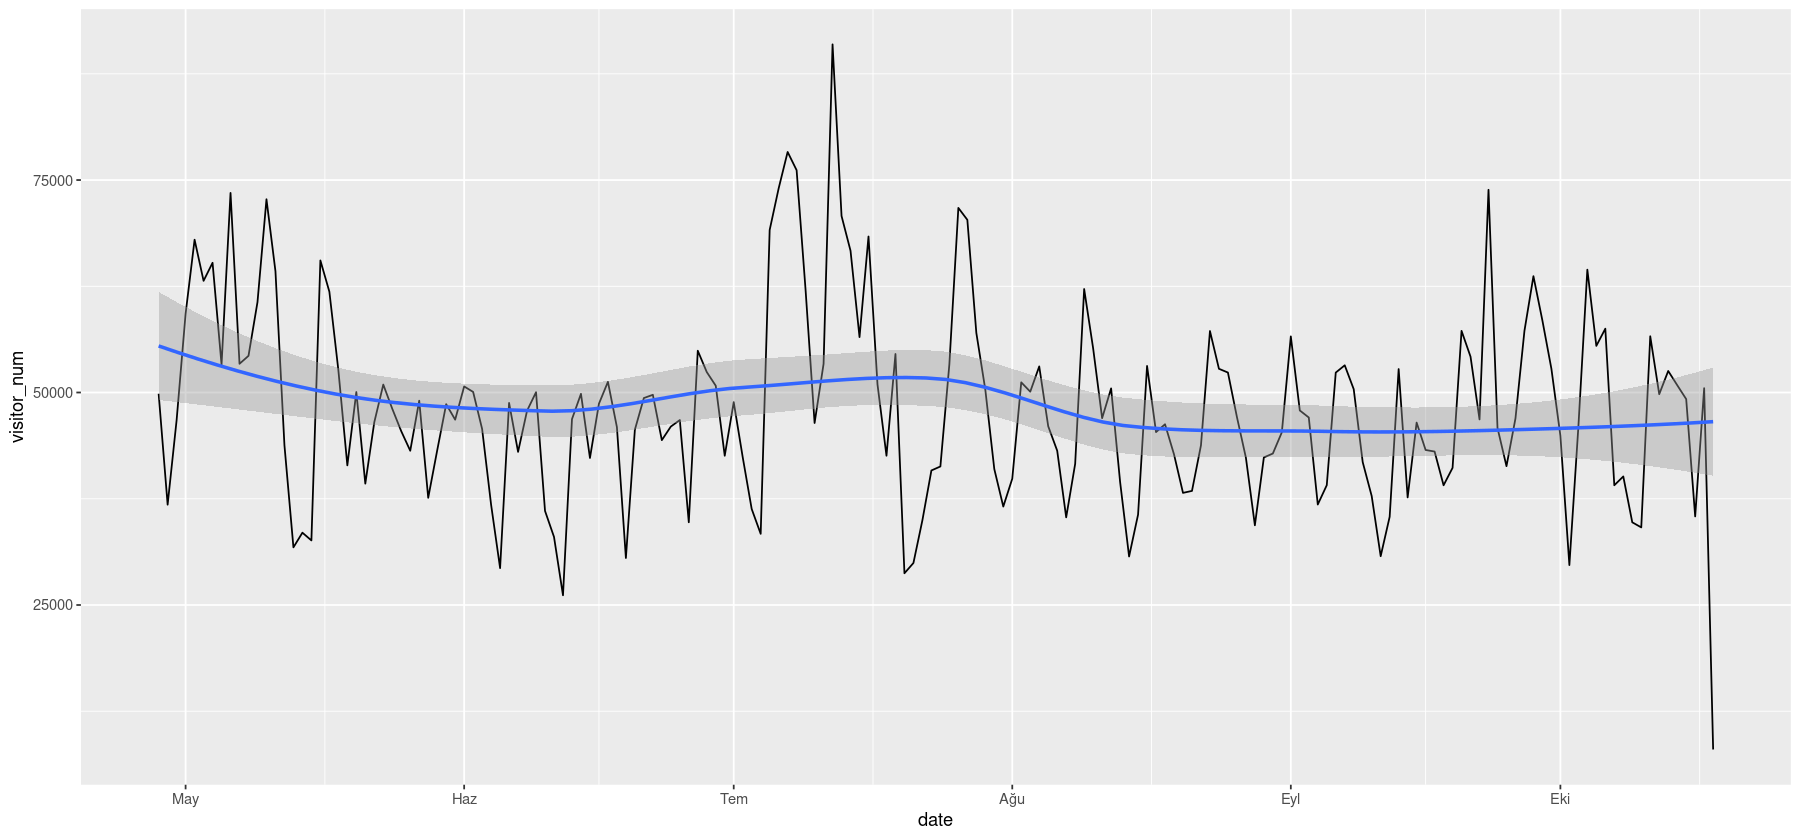

In [96]:
df %>% 
group_by(date) %>% 
summarise(visitor_num = sum(visitor_num),usdtry=mean(usdtry)) %>% 
ggplot(aes(date,visitor_num))+
geom_line()+
geom_smooth(method = 'loess',formula=y~x)

### Point 3 :

In aggregate way again, when we sum up the number of visitors, we can see that the most visited season is May and July and starts to decrease after July (which supports my inference at `Point 2`). To show more clear, I added a smooth line to the time series above.

### I am labelling weekends

Warning message:
“Removed 124 rows containing missing values (geom_point).”


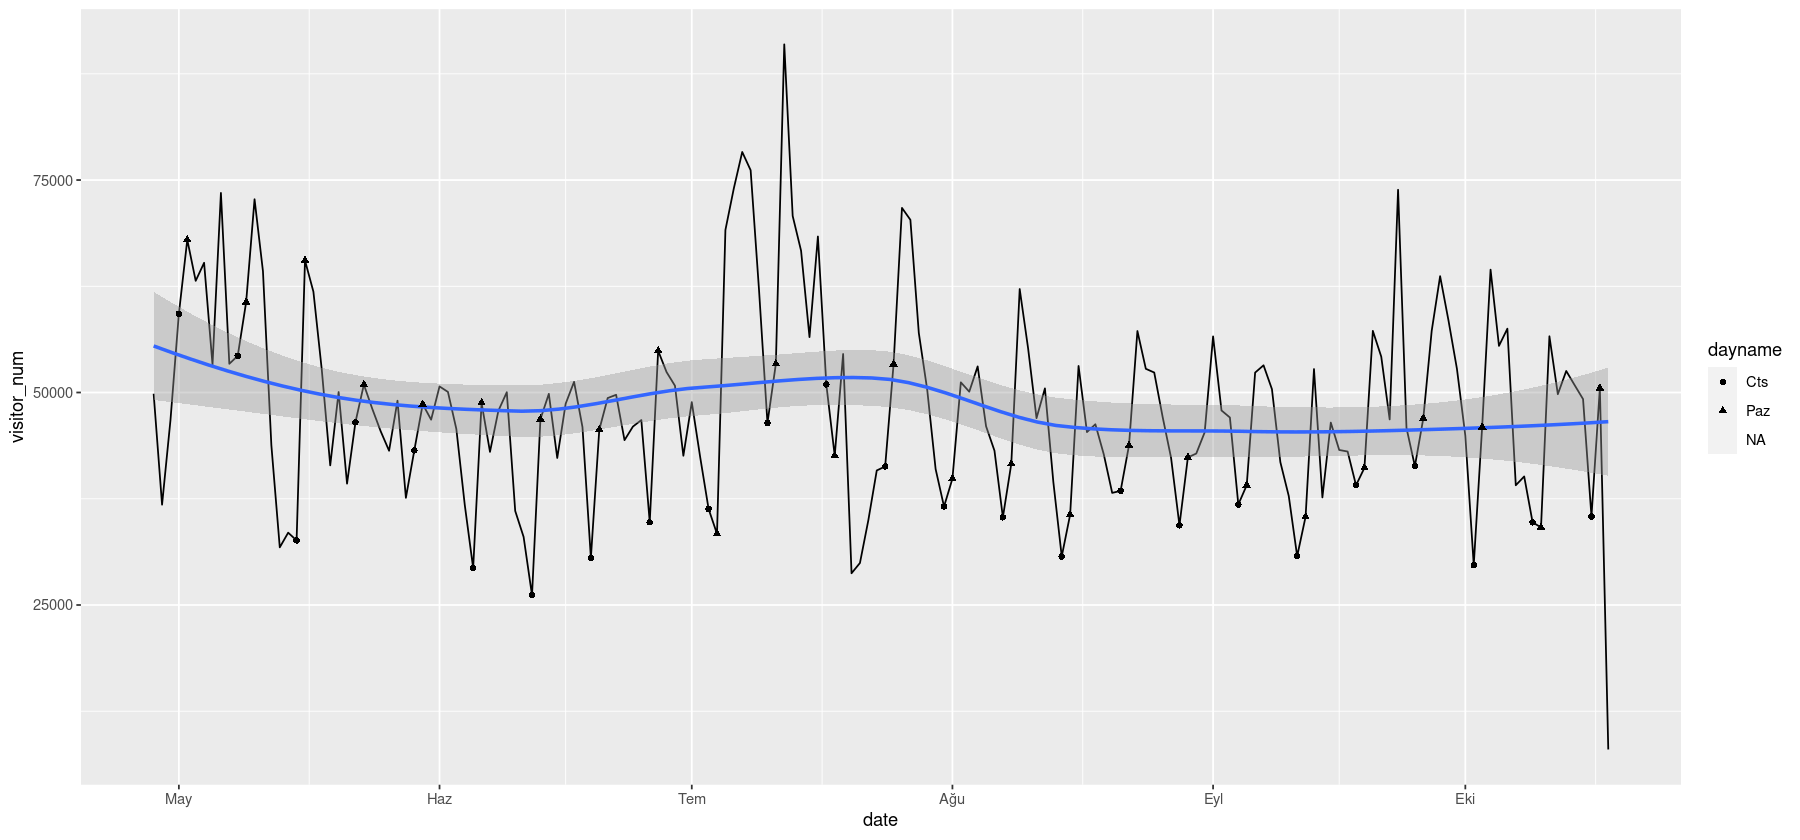

In [117]:
df %>% 
group_by(date,week_day) %>% 
summarise(visitor_num = sum(visitor_num),.groups='drop')  %>% 
mutate(weekend = ifelse(week_day=='Cts' | week_day=='Paz',as.character(date),NA)) %>% 
mutate(weekend = as.Date(weekend)) %>%
mutate(dayname = ifelse(is.na(weekend),NA,week_day)) %>%
ggplot(aes(date,visitor_num))+
geom_line()+
geom_smooth(method='loess',formula=y~x)+
geom_point(aes(weekend,visitor_num,shape=dayname))

### Point 4 :

- Until July, local maximums were seen on weekends, then local minimums started to be seen on weekends.


`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



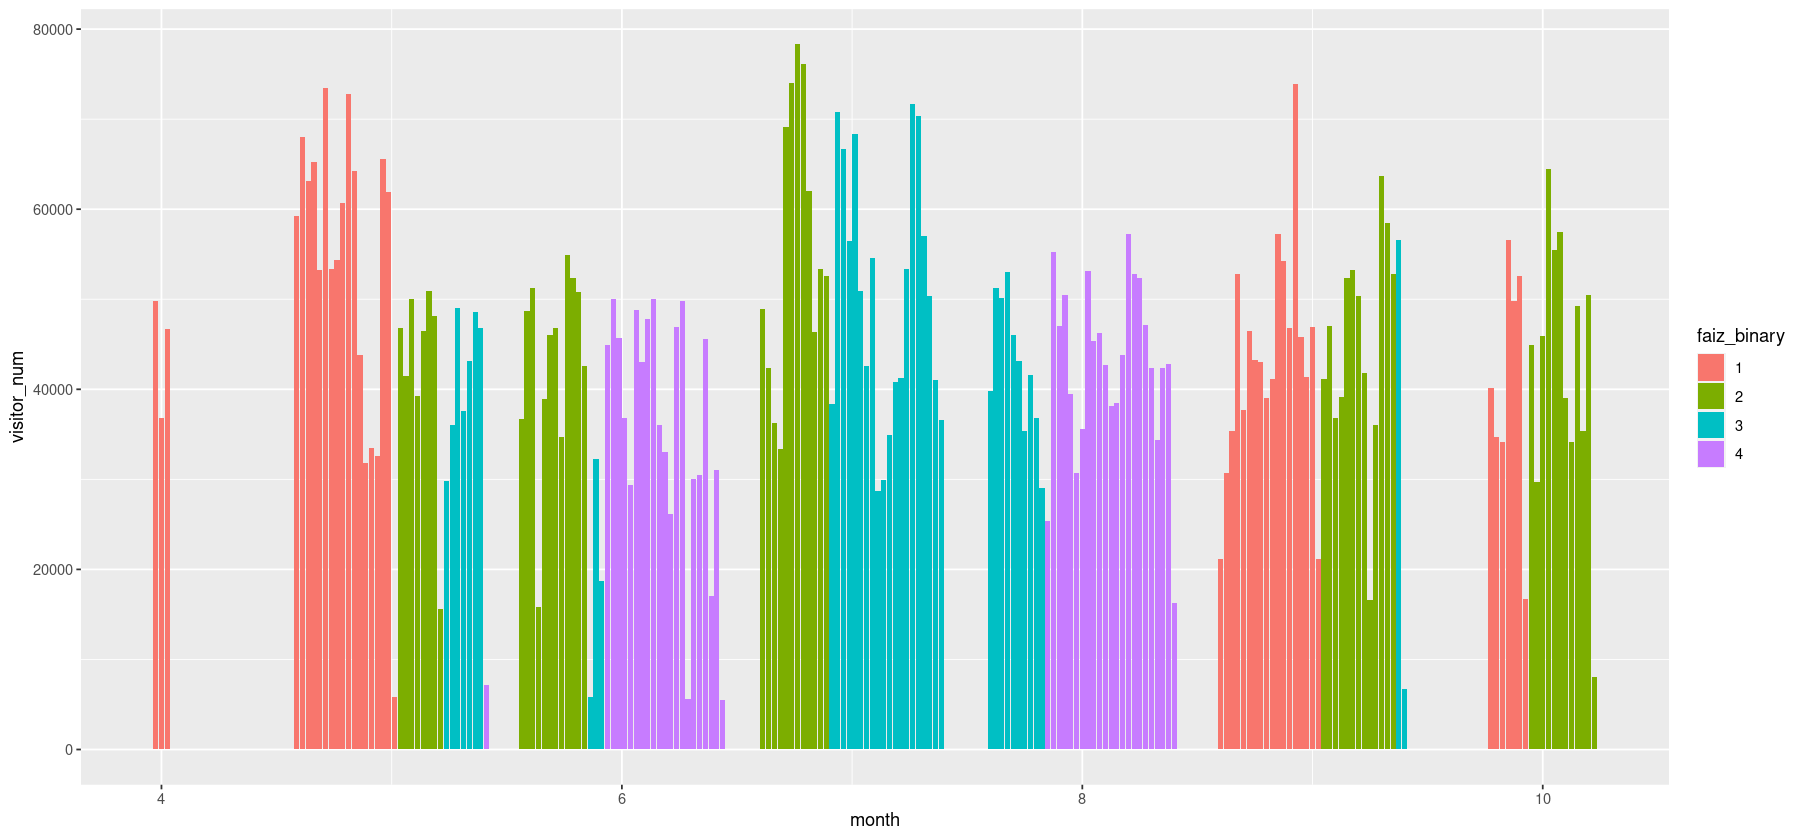

In [141]:
df %>% 
mutate(faiz_binary = cut(faiz,c(-Inf,quantile(faiz,c(0.25,0.5,0.75)),Inf),labels = 1:4)) %>% 
group_by(date,faiz_binary) %>% 
summarise(visitor_num = sum(visitor_num)) %>% 
mutate(month = month(date)) %>% 
ggplot(aes(month,visitor_num))+
geom_bar(aes(fill=faiz_binary),stat='identity',position=position_dodge2(preserve = 'single'))

### Point 5 : 

I cutted interest rate variable onto 4 categories from its quantiles. I examined this monthly and saw that more visitors come on days with low interest rates during the month.

-------

#### Saving last version of data

In [142]:
df %>% write.fst('data_serialized/aggregate_data.fst')